In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# Load Backdoored Model
# --------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("../data/backdoor_cnn.pth", map_location=device))
model.eval()


Using device: cpu


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST("../data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


In [7]:
def optimize_trigger(target_label, steps=300, lr=0.1):
    mask = torch.rand((1, 1, 28, 28), requires_grad=True, device=device)
    trigger = torch.rand((1, 1, 28, 28), requires_grad=True, device=device)

    optimizer = torch.optim.Adam([mask, trigger], lr=lr)

    target = torch.full((128,), target_label, dtype=torch.long, device=device)

    for step in tqdm(range(steps), desc=f"Optimizing target {target_label}"):
        imgs, _ = next(iter(test_loader))
        imgs = imgs.to(device)

        applied_trigger = imgs * (1 - torch.sigmoid(mask)) + torch.sigmoid(mask) * torch.sigmoid(trigger)

        out = model(applied_trigger)
        loss = nn.CrossEntropyLoss()(out, target) + 0.01 * torch.norm(mask, p=1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return torch.sigmoid(mask).detach(), torch.sigmoid(trigger).detach()


In [8]:
trigger_masks = []
trigger_patterns = []

for target_class in range(10):
    mask, trig = optimize_trigger(target_class)
    trigger_masks.append(mask.cpu().numpy())
    trigger_patterns.append(trig.cpu().numpy())

print("Done optimizing all classes.")


Optimizing target 9: 100%|███████████████████████████████████████████████████████████| 300/300 [00:08<00:00, 35.71it/s]

Done optimizing all classes.


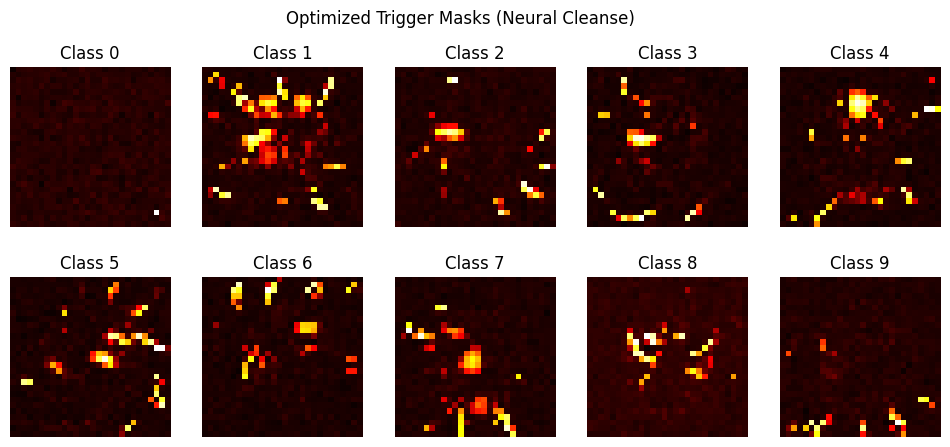

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(trigger_masks[i][0, 0], cmap="hot")
    axes[i].set_title(f"Class {i}")
    axes[i].axis("off")

plt.suptitle("Optimized Trigger Masks (Neural Cleanse)")
plt.show()


In [10]:
mask_norms = [np.sum(mask) for mask in trigger_masks]
print("Mask L1 norms:", mask_norms)

median = np.median(mask_norms)
mad = np.median(np.abs(mask_norms - median))

anomaly_index = [(m - median) / (mad + 1e-6) for m in mask_norms]
print("Anomaly Index:", anomaly_index)


Mask L1 norms: [np.float32(392.47836), np.float32(419.08496), np.float32(402.6989), np.float32(404.03336), np.float32(408.17163), np.float32(407.04047), np.float32(405.693), np.float32(409.17203), np.float32(402.4185), np.float32(400.56445)]
Anomaly Index: [np.float32(-4.3054004), np.float32(4.9440093), np.float32(-0.7523695), np.float32(-0.2884695), np.float32(1.1501436), np.float32(0.7569102), np.float32(0.2884801), np.float32(1.4979175), np.float32(-0.8498557), np.float32(-1.4943846)]
